In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from layoutlmft.models.layoutlmv3.tokenization_layoutlmv3_fast import LayoutLMv3TokenizerFast
import pyarrow
pyarrow.PyExtensionType.set_auto_load(True)

tokenizer = AutoTokenizer.from_pretrained(
    "layoutlmv3-base-1028",
    use_fast=True,
)

dataset = load_dataset("layoutlmft/data/custom_ner.py", name="ie")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

/root/mambaforge/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/mambaforge/envs/env/lib/python3.8/site-packages/datasets/features/features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)


In [2]:
from layoutlmft.data.image_utils import RandomResizedCropAndInterpolationWithTwoPic, pil_loader, Compose

from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision import transforms
import torch
imagenet_default_mean_and_std = False
mean = IMAGENET_INCEPTION_MEAN if not imagenet_default_mean_and_std else IMAGENET_DEFAULT_MEAN
std = IMAGENET_INCEPTION_STD if not imagenet_default_mean_and_std else IMAGENET_DEFAULT_STD
common_transform = Compose([
    # transforms.ColorJitter(0.4, 0.4, 0.4),
    # transforms.RandomHorizontalFlip(p=0.5),
    RandomResizedCropAndInterpolationWithTwoPic(
        size=224, interpolation="bicubic"),
])
patch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=torch.tensor(mean),
        std=torch.tensor(std))
])

In [3]:
label_to_id = {i: i for i in range(7)}
# Tokenize all texts and align the labels with them.
def tokenize_and_align_labels_ner(examples, augmentation=False):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        padding=False,
        truncation=True,
        return_overflowing_tokens=True,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )

    labels = []
    bboxes = []
    images = []
    ro_attns = []
    for batch_index in range(len(tokenized_inputs["input_ids"])):
        word_ids = tokenized_inputs.word_ids(batch_index=batch_index)
        org_batch_index = tokenized_inputs["overflow_to_sample_mapping"][batch_index]
        assert batch_index == org_batch_index

        # read order
        if True:
            ro_attn = [[0] * len(word_ids) for _ in range(len(word_ids))]
            ro_span = examples["ro_spans"][batch_index]
            head_start_words, head_end_words, tail_start_words, tail_end_words = ro_span["head_start"], ro_span["head_end"], ro_span["tail_start"], ro_span["tail_end"]
            for head_start_word, head_end_word, tail_start_word, tail_end_word in zip(head_start_words, head_end_words, tail_start_words, tail_end_words):
                head_start_token = head_end_token = tail_start_token = tail_end_token = None
                for token_idx, word_idx in enumerate(word_ids):
                    if word_idx == head_start_word and head_start_token is None:
                        head_start_token = token_idx
                    if word_idx == head_end_word and head_end_token is None:
                        head_end_token = token_idx
                    if word_idx == tail_start_word and tail_start_token is None:
                        tail_start_token = token_idx
                    if word_idx == tail_end_word and tail_end_token is None:
                        tail_end_token = token_idx
                assert head_start_token is not None and tail_start_token is not None
                if head_end_token is None:
                    head_end_token = len(word_ids) - 1
                if tail_end_token is None:
                    tail_end_token = len(word_ids) - 1
                for i in range(head_start_token, head_end_token):
                    for j in range(tail_start_token, tail_end_token):
                        ro_attn[i][j] = 1
            ro_attns.append(ro_attn)
        
        label = examples["ner_tags"][org_batch_index]
        bbox = examples["bboxes"][org_batch_index]
        previous_word_idx = None
        label_ids = []
        bbox_inputs = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
                bbox_inputs.append([0, 0, 0, 0])
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
                bbox_inputs.append(bbox[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label_to_id[label[word_idx]] if False else -100)
                bbox_inputs.append(bbox[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
        bboxes.append(bbox_inputs)

        if True:
            ipath = examples["image_path"][org_batch_index]
            img = pil_loader(ipath)
            for_patches, _ = common_transform(img, augmentation=augmentation)
            patch = patch_transform(for_patches)
            images.append(patch)

    tokenized_inputs["labels"] = labels
    tokenized_inputs["bbox"] = bboxes
    if True:
        tokenized_inputs["ro_attn"] = ro_attns
    if True:
        tokenized_inputs["images"] = images
    tokenized_inputs["image_path"] = examples["image_path"]

    return tokenized_inputs


In [4]:
# Tokenize all texts and align the start/end indices to the tokenizer
def tokenize_and_align_start_end_re(examples, augmentation=False):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        padding=False,
        truncation=True,
        return_overflowing_tokens=True,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )
    bboxes = []
    images = []
    entities = []
    ro_attns = []
    batch_size = len(tokenized_inputs["input_ids"])
    for batch_index in range(batch_size):
        word_ids = tokenized_inputs.word_ids(batch_index=batch_index)
        ro_attn = [[0] * len(word_ids) for _ in range(len(word_ids))]
        start_word_idxs = examples["entities"][batch_index]["start"]
        end_word_idxs = examples["entities"][batch_index]["end"]
        aligned_start_word_idxs = []
        aligned_end_word_idxs = []
        bbox = examples["bboxes"][batch_index]
        previous_word_idx = None
        # read order
        if True:
            ro_span = examples["ro_spans"][batch_index]
            head_start_words, head_end_words, tail_start_words, tail_end_words = ro_span["head_start"], ro_span["head_end"], ro_span["tail_start"], ro_span["tail_end"]
            for head_start_word, head_end_word, tail_start_word, tail_end_word in zip(head_start_words, head_end_words, tail_start_words, tail_end_words):
                head_start_token = head_end_token = tail_start_token = tail_end_token = None
                for token_idx, word_idx in enumerate(word_ids):
                    if word_idx == head_start_word and head_start_token is None:
                        head_start_token = token_idx
                    if word_idx == head_end_word and head_end_token is None:
                        head_end_token = token_idx
                    if word_idx == tail_start_word and tail_start_token is None:
                        tail_start_token = token_idx
                    if word_idx == tail_end_word and tail_end_token is None:
                        tail_end_token = token_idx
                assert head_start_token is not None and tail_start_token is not None
                if head_end_token is None:
                    head_end_token = len(word_ids) - 1
                if tail_end_token is None:
                    tail_end_token = len(word_ids) - 1
                for i in range(head_start_token, head_end_token):
                    for j in range(tail_start_token, tail_end_token):
                        ro_attn[i][j] = 1
            ro_attns.append(ro_attn)
        # Outer loop: for every entity(bbox_inputs has the same outcome every loop, but to keep the code clean, we put it here)
        for start_word_idx, end_word_idx in zip(start_word_idxs, end_word_idxs):
            bbox_inputs = []
            start_token_idx = None
            end_token_idx = None
            # Inner loop: one pass word_ids to find the start/end token idx(end token idx is the first token of the next word)
            for token_idx, word_idx in enumerate(word_ids):
                # Special tokens have a word id that is None.
                if word_idx is None:
                    bbox_inputs.append([0, 0, 0, 0])
                # the first token of each word.
                elif word_idx != previous_word_idx:
                    bbox_inputs.append(bbox[word_idx])
                    if word_idx == start_word_idx:
                        start_token_idx = token_idx
                    if word_idx == end_word_idx:
                        end_token_idx = token_idx
                else:
                    bbox_inputs.append(bbox[word_idx])
                previous_word_idx = word_idx
            assert start_token_idx is not None
            if end_token_idx is None:
                end_token_idx = len(word_ids) - 1 # -1 because the last token is a special token
            aligned_start_word_idxs.append(start_token_idx)
            aligned_end_word_idxs.append(end_token_idx)
            
        bboxes.append(bbox_inputs)
        entities.append({
            "start": aligned_start_word_idxs,
            "end": aligned_end_word_idxs,
            "label": examples["entities"][batch_index]["label"],
        })
        if True:
            ipath = examples["image_path"][batch_index]
            img = pil_loader(ipath)
            for_patches, _ = common_transform(img, augmentation=augmentation)
            patch = patch_transform(for_patches)
            images.append(patch)
    tokenized_inputs["bbox"] = bboxes
    tokenized_inputs["entities"] = entities
    tokenized_inputs["relations"] = examples["relations"]
    # dummy labels because the trainer needs them
    tokenized_inputs["labels"] = [10000] * batch_size
    if True:
        tokenized_inputs["ro_attn"] = ro_attns
    if True:
        tokenized_inputs["images"] = images
    return tokenized_inputs

In [5]:
train_dataset_mapped = train_dataset.map(tokenize_and_align_labels_ner, batched=True, remove_columns=train_dataset.column_names, batch_size=1)
test_dataset_mapped = test_dataset.map(tokenize_and_align_labels_ner, batched=True, remove_columns=test_dataset.column_names, batch_size=1)

/root/mambaforge/envs/env/lib/python3.8/site-packages/datasets/features/features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
Map: 100%|██████████| 50/50 [00:02<00:00, 19.34 examples/s]


In [6]:
def unit_test(ro_attn, row_start=1, row_end=9, col_start=43, col_end=47):
    ok = True
    for i in range(row_start, row_end):
        for j in range(col_start, col_end):
            ok &= ro_attn[i][j] == 1
    for j in range(col_start, col_end):
        ok &= ro_attn[row_start - 1][j] == 0
    for j in range(col_start, col_end):
        ok &= ro_attn[row_end][j] == 0
    for i in range(row_start, row_end):
        ok &= ro_attn[i][col_start - 1] == 0
    for i in range(row_start, row_end):
        ok &= ro_attn[i][col_end] == 0
    return ok

In [7]:
example2 = train_dataset[30]
tokenization = tokenizer(example2["tokens"], padding=False, truncation=True, return_overflowing_tokens=True, is_split_into_words=True)
word_ids = tokenization.word_ids(0)
cnt=0
for head_start_word, head_end_word, tail_start_word, tail_end_word in zip(example2["ro_spans"]["head_start"], example2["ro_spans"]["head_end"], example2["ro_spans"]["tail_start"], example2["ro_spans"]["tail_end"]):
    head_start_token = head_end_token = tail_start_token = tail_end_token = None
    for token_idx, word_idx in enumerate(word_ids):
        if word_idx == head_start_word and head_start_token is None:
            head_start_token = token_idx
        if word_idx == head_end_word and head_end_token is None:
            head_end_token = token_idx
        if word_idx == tail_start_word and tail_start_token is None:
            tail_start_token = token_idx
        if word_idx == tail_end_word and tail_end_token is None:
            tail_end_token = token_idx
    assert head_start_token is not None and tail_start_token is not None
    if head_end_token is None:
        head_end_token = len(word_ids) - 1
    if tail_end_token is None:
        tail_end_token = len(word_ids) - 1
    for i in range(head_start_token, head_end_token):
        for j in range(tail_start_token, tail_end_token):
            cnt+=1
            print(i, j)
print(cnt)

1 43
1 44
1 45
1 46
2 43
2 44
2 45
2 46
3 43
3 44
3 45
3 46
4 43
4 44
4 45
4 46
5 43
5 44
5 45
5 46
6 43
6 44
6 45
6 46
7 43
7 44
7 45
7 46
8 43
8 44
8 45
8 46
9 19
9 20
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
11 26
11 27
11 28
11 29
11 30
11 31
11 32
11 33
11 34
11 35
11 36
11 37
11 38
12 26
12 27
12 28
12 29
12 30
12 31
12 32
12 33
12 34
12 35
12 36
12 37
12 38
13 65
13 66
13 67
13 68
13 69
14 65
14 66
14 67
14 68
14 69
15 65
15 66
15 67
15 68
15 69
16 72
16 73
16 74
17 70
17 71
18 70
18 71
19 21
19 22
19 23
19 24
19 25
20 21
20 22
20 23
20 24
20 25
26 75
26 76
26 77
27 75
27 76
27 77
28 75
28 76
28 77
29 75
29 76
29 77
30 75
30 76
30 77
31 75
31 76
31 77
32 75
32 76
32 77
33 75
33 76
33 77
34 75
34 76
34 77
35 75
35 76
35 77
36 75
36 76
36 77
37 75
37 76
37 77
38 75
38 76
38 77
39 134
39 135
39 136
39 137
39 138
39 139
39 140
39 141
40 134
40 135
40 136
40 137
40 138
40 139
40 140
40 141
41 134
41 135
41 136
41 137
41 138
41 139
41 140
41 141
42

In [8]:
print(list(enumerate(example2["tokens"])))
print(example2["ro_spans"]["head_start"])
print(example2["ro_spans"]["head_end"])
print(example2["ro_spans"]["tail_start"])
print(example2["ro_spans"]["tail_end"])
print(list(enumerate(word_ids)))

[(0, 'Total'), (1, 'V.'), (2, 'O.'), (3, 'C.'), (4, 's'), (5, 'Technician'), (6, 'Total'), (7, 'Solids'), (8, 'Formula'), (9, 'No.'), (10, 'Customer'), (11, 'Product'), (12, 'Name'), (13, 'DLR'), (14, '12/'), (15, '5/'), (16, '89'), (17, 'Solvent'), (18, 'Composit'), (19, 'to'), (20, '%'), (21, 'V.'), (22, 'O.'), (23, 'C.'), (24, 's'), (25, 'Solids'), (26, 'Composit'), (27, '100.'), (28, '00%'), (29, 'AARBERG'), (30, '-STRAHAN'), (31, 'INKS'), (32, '&'), (33, 'COATINGS'), (34, 'CORP.'), (35, 'SKGC-4518'), (36, 'Falcon'), (37, 'Green'), (38, 'B&W'), (39, 'Toluene'), (40, 'N-'), (41, 'Propyl'), (42, 'Acetate'), (43, 'Isopropyl'), (44, 'Acetate'), (45, 'Pigment,'), (46, 'Yellow'), (47, '34'), (48, 'Pigment,'), (49, 'Blue'), (50, '15:'), (51, '4'), (52, 'Cellulose'), (53, 'Nitrate'), (54, 'Wet'), (55, 'w'), (56, '/2'), (57, 'Propanol'), (58, 'Ester'), (59, 'of'), (60, 'Modified'), (61, 'Tricyclic'), (62, 'Carboxylic'), (63, 'Acid'), (64, 'Jonrez'), (65, 'IM824'), (66, 'Lecithin'), (67, '(F

In [9]:
# names=["O", "B-HEADER", "I-HEADER", "B-QUESTION", "I-QUESTION", "B-ANSWER", "I-ANSWER"]
label_id_to_name = {0: "O", 1: "B-HEADER", 2: "I-HEADER", 3: "B-QUESTION", 4: "I-QUESTION", 5: "B-ANSWER", 6: "I-ANSWER", -100: "PAD"}
ner_tags = [label_id_to_name[tag] for tag in example2["ner_tags"]]
print(list(enumerate(ner_tags)))
print(list(enumerate(example2["tokens"])))

[(0, 'B-QUESTION'), (1, 'I-QUESTION'), (2, 'I-QUESTION'), (3, 'I-QUESTION'), (4, 'I-QUESTION'), (5, 'B-QUESTION'), (6, 'B-QUESTION'), (7, 'I-QUESTION'), (8, 'B-QUESTION'), (9, 'I-QUESTION'), (10, 'B-QUESTION'), (11, 'O'), (12, 'O'), (13, 'B-ANSWER'), (14, 'I-ANSWER'), (15, 'I-ANSWER'), (16, 'I-ANSWER'), (17, 'B-ANSWER'), (18, 'I-ANSWER'), (19, 'I-ANSWER'), (20, 'I-ANSWER'), (21, 'I-ANSWER'), (22, 'I-ANSWER'), (23, 'I-ANSWER'), (24, 'I-ANSWER'), (25, 'B-QUESTION'), (26, 'I-QUESTION'), (27, 'B-ANSWER'), (28, 'I-ANSWER'), (29, 'B-HEADER'), (30, 'I-HEADER'), (31, 'I-HEADER'), (32, 'I-HEADER'), (33, 'I-HEADER'), (34, 'I-HEADER'), (35, 'B-ANSWER'), (36, 'O'), (37, 'O'), (38, 'B-ANSWER'), (39, 'B-ANSWER'), (40, 'B-ANSWER'), (41, 'I-ANSWER'), (42, 'I-ANSWER'), (43, 'B-ANSWER'), (44, 'I-ANSWER'), (45, 'B-ANSWER'), (46, 'I-ANSWER'), (47, 'I-ANSWER'), (48, 'B-ANSWER'), (49, 'I-ANSWER'), (50, 'I-ANSWER'), (51, 'I-ANSWER'), (52, 'B-ANSWER'), (53, 'I-ANSWER'), (54, 'I-ANSWER'), (55, 'I-ANSWER'), (56

In [10]:
ner_tags_mapped = [label_id_to_name[tag] for tag in train_dataset_mapped["labels"][30]]
print(list(enumerate(ner_tags_mapped)))
print(list(enumerate(word_ids)))

[(0, 'PAD'), (1, 'B-QUESTION'), (2, 'I-QUESTION'), (3, 'PAD'), (4, 'I-QUESTION'), (5, 'PAD'), (6, 'I-QUESTION'), (7, 'PAD'), (8, 'I-QUESTION'), (9, 'B-QUESTION'), (10, 'B-QUESTION'), (11, 'I-QUESTION'), (12, 'PAD'), (13, 'B-QUESTION'), (14, 'I-QUESTION'), (15, 'PAD'), (16, 'B-QUESTION'), (17, 'O'), (18, 'O'), (19, 'B-ANSWER'), (20, 'PAD'), (21, 'I-ANSWER'), (22, 'PAD'), (23, 'I-ANSWER'), (24, 'PAD'), (25, 'I-ANSWER'), (26, 'B-ANSWER'), (27, 'PAD'), (28, 'I-ANSWER'), (29, 'PAD'), (30, 'I-ANSWER'), (31, 'I-ANSWER'), (32, 'I-ANSWER'), (33, 'PAD'), (34, 'I-ANSWER'), (35, 'PAD'), (36, 'I-ANSWER'), (37, 'PAD'), (38, 'I-ANSWER'), (39, 'B-QUESTION'), (40, 'PAD'), (41, 'I-QUESTION'), (42, 'PAD'), (43, 'B-ANSWER'), (44, 'PAD'), (45, 'I-ANSWER'), (46, 'PAD'), (47, 'B-HEADER'), (48, 'PAD'), (49, 'PAD'), (50, 'PAD'), (51, 'I-HEADER'), (52, 'PAD'), (53, 'PAD'), (54, 'PAD'), (55, 'PAD'), (56, 'I-HEADER'), (57, 'PAD'), (58, 'I-HEADER'), (59, 'I-HEADER'), (60, 'PAD'), (61, 'PAD'), (62, 'I-HEADER'), (63

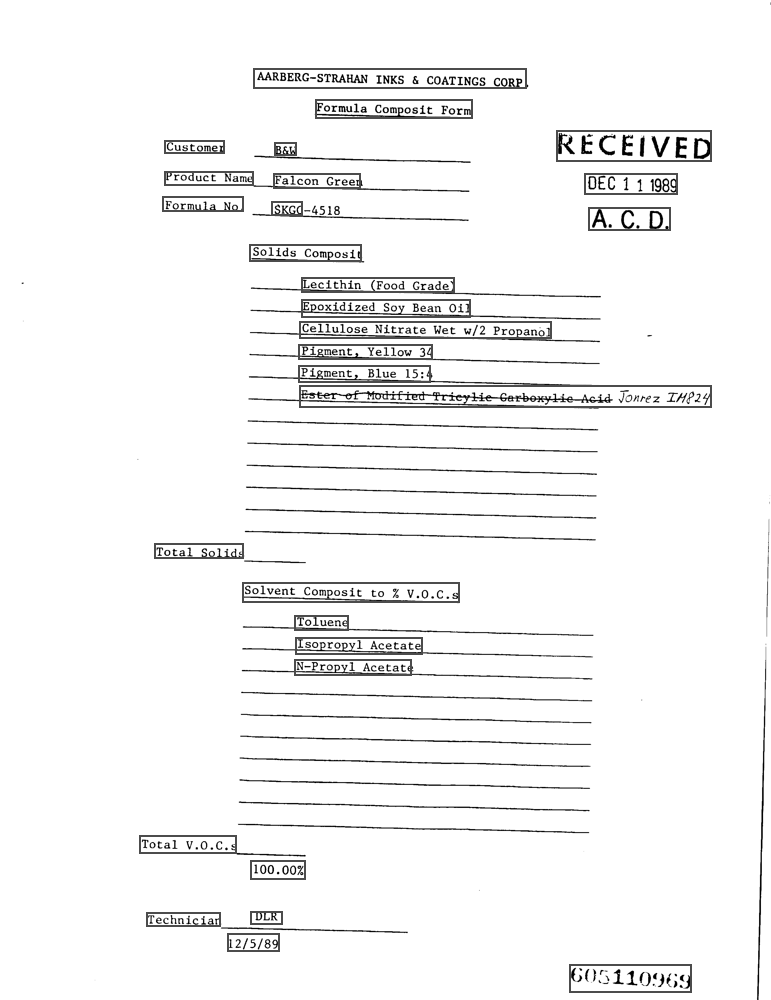

In [11]:
from PIL import ImageDraw
from PIL import Image

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def draw_boxes(image, boxes, color='red', width=2):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(unnormalize_box(box, image.width, image.height), outline=color, width=width)
    return image

image = Image.open(example2['image_path'])
draw_boxes(image, example2['bboxes']).show()

In [20]:
from layoutlmft.models.layoutlmv3.modeling_layoutlmv3 import LayoutLMv3ForTokenClassification
trained_model = LayoutLMv3ForTokenClassification.from_pretrained(
    "results/layoutlmv3-base-finetuned-custom-ner"
)

In [21]:
example2_mapped = train_dataset_mapped[30]
trained_model.eval()
from layoutlmft.data.data_collator import DataCollatorForKeyValueExtraction
collator = DataCollatorForKeyValueExtraction(tokenizer, max_length=1024, padding="max_length")
batch = collator([example2_mapped])
output = trained_model(
    input_ids=batch["input_ids"],
    bbox=batch["bbox"],
    attention_mask=batch["attention_mask"],
    ro_attn=batch["ro_attn"],
    labels=batch["labels"],
    images=batch["images"],
    return_dict=True,
)

In [22]:
trained_model.eval()
from layoutlmft.data.data_collator import DataCollatorForKeyValueExtraction
from torch.utils.data import DataLoader
collator = DataCollatorForKeyValueExtraction(tokenizer, max_length=1024, padding="max_length")
loader = DataLoader(test_dataset_mapped, batch_size=50, collate_fn=collator)
batch = next(iter(loader))
output = trained_model(
    input_ids=batch["input_ids"],
    bbox=batch["bbox"],
    attention_mask=batch["attention_mask"],
    ro_attn=batch["ro_attn"],
    labels=batch["labels"],
    images=batch["images"],
    return_dict=True,
)

In [49]:
pred = [label_id_to_name[l.item()] for i, l in enumerate(torch.argmax(output[1][0], -1)) if batch["labels"][0][i] != -100]
labels = [label_id_to_name[l.item()] for l in batch["labels"][0] if l != -100]

In [50]:
print(list(enumerate(pred)))
print(list(enumerate(labels)))

[(0, 'B-QUESTION'), (1, 'I-QUESTION'), (2, 'I-QUESTION'), (3, 'I-QUESTION'), (4, 'I-QUESTION'), (5, 'B-QUESTION'), (6, 'B-QUESTION'), (7, 'I-QUESTION'), (8, 'B-QUESTION'), (9, 'I-QUESTION'), (10, 'B-QUESTION'), (11, 'O'), (12, 'O'), (13, 'B-ANSWER'), (14, 'I-ANSWER'), (15, 'I-ANSWER'), (16, 'I-ANSWER'), (17, 'B-ANSWER'), (18, 'I-ANSWER'), (19, 'I-ANSWER'), (20, 'I-ANSWER'), (21, 'I-ANSWER'), (22, 'I-ANSWER'), (23, 'I-ANSWER'), (24, 'I-ANSWER'), (25, 'B-QUESTION'), (26, 'I-QUESTION'), (27, 'B-ANSWER'), (28, 'I-ANSWER'), (29, 'B-HEADER'), (30, 'I-HEADER'), (31, 'I-HEADER'), (32, 'I-HEADER'), (33, 'I-HEADER'), (34, 'I-HEADER'), (35, 'B-ANSWER'), (36, 'O'), (37, 'O'), (38, 'B-ANSWER'), (39, 'B-ANSWER'), (40, 'B-ANSWER'), (41, 'I-ANSWER'), (42, 'I-ANSWER'), (43, 'B-ANSWER'), (44, 'I-ANSWER'), (45, 'B-ANSWER'), (46, 'I-ANSWER'), (47, 'I-ANSWER'), (48, 'B-ANSWER'), (49, 'I-ANSWER'), (50, 'I-ANSWER'), (51, 'I-ANSWER'), (52, 'B-ANSWER'), (53, 'I-ANSWER'), (54, 'I-ANSWER'), (55, 'I-ANSWER'), (56